In [1]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Tentukan path ke params.json
params_path = Path.home() / "Desktop" / "rbi-lite" / "data" / "params.json"

# 2) Load params
with open(params_path, "r", encoding="utf-8") as f:
    params = json.load(f)

params

{'asset_name': 'Carbon Steel Pipe (demo)',
 't0_mm': 12.0,
 't_min_mm': 7.0,
 'r_mean_mm_per_year': 0.8,
 'r_std_mm_per_year': 0.25,
 'meas_std_mm': 0.2,
 'horizon_years': 10,
 'n_mc': 20000}

In [2]:
#Mengubah parameter ke variabel
t0 = float(params["t0_mm"])
t_min = float(params["t_min_mm"])
r_mean = float(params["r_mean_mm_per_year"])
r_std = float(params["r_std_mm_per_year"])
meas_std = float(params["meas_std_mm"])
horizon_years = int(params["horizon_years"])
n_mc = int(params.get("n_mc", 20000))

print("t0 (mm):", t0)
print("t_min (mm):", t_min)
print("r_mean (mm/yr):", r_mean)
print("r_std (mm/yr):", r_std)
print("horizon_years:", horizon_years)
print("n_mc:", n_mc)

t0 (mm): 12.0
t_min (mm): 7.0
r_mean (mm/yr): 0.8
r_std (mm/yr): 0.25
horizon_years: 10
n_mc: 20000


In [3]:
# time grid: per bulan selama horizon_years
dt_year = 1/12  # 1 bulan dalam tahun
time_years = np.arange(0, horizon_years + dt_year, dt_year)  # termasuk tahun terakhir
len(time_years), time_years[:5], time_years[-5:]

(122,
 array([0.        , 0.08333333, 0.16666667, 0.25      , 0.33333333]),
 array([ 9.75      ,  9.83333333,  9.91666667, 10.        , 10.08333333]))

In [4]:
rng = np.random.default_rng(42)  # untuk hasil konsisten (reproducible)

# sample corrosion rates r untuk n_mc skenario
r_samples = rng.normal(loc=r_mean, scale=r_std, size=n_mc)

# memastikan tidak ada laju korosi negatif (secara fisik)
r_samples = np.clip(r_samples, a_min=0.0, a_max=None)

pd.Series(r_samples).describe()

count    20000.000000
mean         0.801317
std          0.250993
min          0.000000
25%          0.632475
50%          0.799572
75%          0.968192
max          1.837810
dtype: float64

In [5]:
# thickness matrix: shape (n_mc, n_time)
# t = t0 - r * time
thickness = t0 - np.outer(r_samples, time_years)

thickness.shape

(20000, 122)

In [6]:
failed = thickness < t_min  # matrix True/False
pof_vs_time = failed.mean(axis=0)  # rata-rata across skenario untuk peluang gagal

pof_df = pd.DataFrame({
    "time_years": time_years,
    "pof": pof_vs_time
})

pof_df.head(), pof_df.tail()

(   time_years  pof
 0    0.000000  0.0
 1    0.083333  0.0
 2    0.166667  0.0
 3    0.250000  0.0
 4    0.333333  0.0,
      time_years      pof
 117    9.750000  0.87525
 118    9.833333  0.87825
 119    9.916667  0.88105
 120   10.000000  0.88480
 121   10.083333  0.88775)

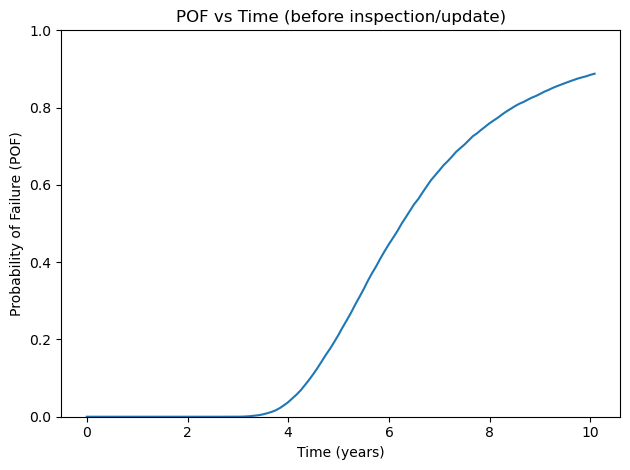

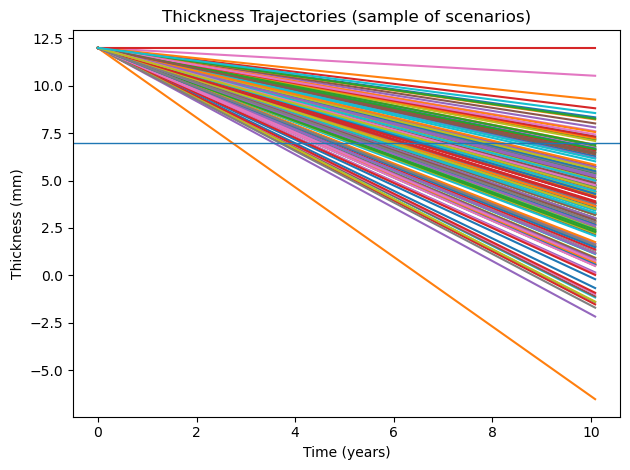

Saved figures to: C:\Users\LENOVO\Desktop\rbi-lite\figures


In [7]:
fig_dir = Path.home() / "Desktop" / "rbi-lite" / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

# Save POF plot
plt.figure()
plt.plot(time_years, pof_vs_time)
plt.xlabel("Time (years)")
plt.ylabel("Probability of Failure (POF)")
plt.title("POF vs Time (before inspection/update)")
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig(fig_dir / "step2_pof_vs_time.png", dpi=200)
plt.show()

# Save thickness sample plot
# pilih beberapa skenario acak untuk diplot
idx = rng.choice(n_mc, size=min(200, n_mc), replace=False)

plt.figure()
plt.plot(time_years, thickness[idx].T)
plt.axhline(t_min, linewidth=1)
plt.xlabel("Time (years)")
plt.ylabel("Thickness (mm)")
plt.title("Thickness Trajectories (sample of scenarios)")
plt.tight_layout()
plt.savefig(fig_dir / "step2_thickness_samples.png", dpi=200)
plt.show()

print("Saved figures to:", fig_dir)